# BDT: Comparison to Previous Method
____

Here we calculate the top mass reconstruction efficiency of the BDT compared to the previous method, which selected the trijet combination with the highest $p_T$.

In [8]:
## IMPORTS
import os
import time

import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
from coffea.nanoevents import NanoEventsFactory
import awkward as ak

import xgboost as xgb

import utils

In [2]:
DICT_MAX = 7 # maximum permutation number to include in dictionaries

# calculate the dictionary of permutations for each number of jets
permutations_dict = {}
for n in range(4,DICT_MAX+1):
    test = ak.Array(range(n))
    unzipped = ak.unzip(ak.argcartesian([test]*4,axis=0))

    combos = ak.combinations(ak.Array(range(4)), 2, axis=0)
    different = unzipped[combos[0]["0"]]!=unzipped[combos[0]["1"]]
    for i in range(1,len(combos)):
        different = different & (unzipped[combos[i]["0"]]!=unzipped[combos[i]["1"]])

    permutations = ak.zip([test[unzipped[i][different]] for i in range(len(unzipped))],
                          depth_limit=1).tolist()


    permutations = ak.concatenate([test[unzipped[i][different]][..., np.newaxis] 
                                   for i in range(len(unzipped))], 
                                  axis=1).to_list()
    
    permutations_dict[n] = permutations
    
# for each permutation, calculate the corresponding label
labels_dict = {}
for n in range(4,DICT_MAX+1):
    
    current_labels = []
    for inds in permutations_dict[n]:
        
        inds = np.array(inds)
        current_label = 100*np.ones(n)
        current_label[inds[:2]] = 24
        current_label[inds[2]] = 6
        current_label[inds[3]] = -6
        current_labels.append(current_label.tolist())
        
    labels_dict[n] = current_labels
    
# get rid of duplicates since we consider W jets to be exchangeable
# (halves the number of permutations we consider)
for n in range(4,DICT_MAX+1):
    res = []
    for idx, val in enumerate(labels_dict[n]):
        if val in labels_dict[n][:idx]:
            res.append(idx)
    labels_dict[n] = np.array(labels_dict[n])[res].tolist()
    permutations_dict[n] = np.array(permutations_dict[n])[res].tolist()
    print("number of permutations for n=",n,": ", len(permutations_dict[n]))

number of permutations for n= 4 :  12
number of permutations for n= 5 :  60
number of permutations for n= 6 :  180
number of permutations for n= 7 :  420


In [3]:
# these matrices tell you the overlap between the predicted label (rows) and truth label (columns)
# the "score" in each matrix entry is the number of jets which are assigned correctly
evaluation_matrices = {} # overall event score
evaluation_matrices_W = {} # score for W jets
evaluation_matrices_top2 = {} # score for top2 jet
evaluation_matrices_top1 = {} # score for top1 jet
evaluation_matrices_topmass = {} # score for which three jets are used for top mass reconstruction

for n in range(4,DICT_MAX+1):
    print("n = ", n)
    
    evaluation_matrix_topmass = np.zeros((len(permutations_dict[n]),len(permutations_dict[n])))
    
    for i in range(len(permutations_dict[n])):
        current_i = np.array(labels_dict[n][i])
        
        for j in range(len(permutations_dict[n])):
            current_j = np.array(labels_dict[n][j])
        
            evaluation_matrix_topmass[i,j] = len(np.intersect1d(np.where(((current_i==24) | (current_i==6)))[0], 
                                                                np.where(((current_j==24) | (current_j==6)))[0]))
    evaluation_matrices_topmass[n] = evaluation_matrix_topmass

n =  4
n =  5
n =  6
n =  7


In [4]:
## get inputs to BDT
def get_features(jets, electrons, muons, permutations_dict):
    '''
    Calculate features for each of the 12 combinations per event
    
    Args:
        jets: selected jets
        electrons: selected electrons
        muons: selected muons
        permutations_dict: which permutations to consider for each number of jets in an event
    
    Returns:
        features (flattened to remove event level)
    '''
    
    # calculate number of jets in each event
    njet = ak.num(jets).to_numpy()
    # don't consider every jet for events with high jet multiplicity
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[n] for n in njet])
    perm_counts = ak.num(perms)
    
    
    #### calculate features ####
    #### calculate features ####
    features = np.zeros((sum(perm_counts),20))
    
    # grab lepton info
    leptons = ak.flatten(ak.concatenate((electrons, muons),axis=1),axis=-1)

    feature_count = 0
    
    # delta R between top1 and lepton
    features[:,0] = ak.flatten(np.sqrt((leptons.eta - jets[perms[...,3]].eta)**2 + 
                                       (leptons.phi - jets[perms[...,3]].phi)**2)).to_numpy()

    
    #delta R between the two W
    features[:,1] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,1]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,1]].phi)**2)).to_numpy()

    #delta R between W and top2
    features[:,2] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,2]].phi)**2)).to_numpy()
    features[:,3] = ak.flatten(np.sqrt((jets[perms[...,1]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,1]].phi - jets[perms[...,2]].phi)**2)).to_numpy()

    # combined mass of top1 and lepton
    features[:,4] = ak.flatten((leptons + jets[perms[...,3]]).mass).to_numpy()

    # combined mass of W
    features[:,5] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]]).mass).to_numpy()

    # combined mass of W and top2
    features[:,6] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]] + 
                                 jets[perms[...,2]]).mass).to_numpy()
    
    feature_count+=1
    # combined pT of W and top2
    features[:,7] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]] + 
                                 jets[perms[...,2]]).pt).to_numpy()


    # pt of every jet
    features[:,8] = ak.flatten(jets[perms[...,0]].pt).to_numpy()
    features[:,9] = ak.flatten(jets[perms[...,1]].pt).to_numpy()
    features[:,10] = ak.flatten(jets[perms[...,2]].pt).to_numpy()
    features[:,11] = ak.flatten(jets[perms[...,3]].pt).to_numpy()

    # btagCSVV2 of every jet
    features[:,12] = ak.flatten(jets[perms[...,0]].btagCSVV2).to_numpy()
    features[:,13] = ak.flatten(jets[perms[...,1]].btagCSVV2).to_numpy()
    features[:,14] = ak.flatten(jets[perms[...,2]].btagCSVV2).to_numpy()
    features[:,15] = ak.flatten(jets[perms[...,3]].btagCSVV2).to_numpy()
    
    # qgl of every jet
    features[:,16] = ak.flatten(jets[perms[...,0]].qgl).to_numpy()
    features[:,17] = ak.flatten(jets[perms[...,1]].qgl).to_numpy()
    features[:,18] = ak.flatten(jets[perms[...,2]].qgl).to_numpy()
    features[:,19] = ak.flatten(jets[perms[...,3]].qgl).to_numpy()

    return features, perm_counts

In [5]:
def filterEvents(jets, electrons, muons, genpart, even, nmin, nmax, reconstructable=True):

    
    # selected_electrons = electrons[electrons.pt > 25]
    selected_electrons = electrons[(electrons.pt > 30) & (np.abs(electrons.eta)<2.1) & (electrons.sip3d < 4) & (electrons.cutBased==4)]
    # selected_muons = muons[muons.pt > 25]
    selected_muons = events.Muon[(muons.pt > 30) & (np.abs(muons.eta)<2.1) & (muons.tightId) & 
                                 (muons.sip3d < 4) & (muons.pfRelIso04_all < 0.15)]
    # jet_filter = (jets.pt > 25)
    jet_filter = (jets.pt > 30) & (np.abs(jets.eta) < 2.4)
    selected_jets = jets[jet_filter]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= nmin)
    # at least one b-tagged jet ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

    print("        ", 100*np.round(sum(event_filters)/num_events,4), "% of events survived event_filters")

    selected_events = events[event_filters]
    selected_electrons = selected_electrons[event_filters]
    selected_muons = selected_muons[event_filters]
    selected_jets = selected_jets[event_filters]
    selected_genpart = genpart[event_filters]
    selected_even = even[event_filters]

    ### only consider 4j2b region
    region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2

    print("        ", 100*np.round(sum(region_filter)/num_events,4), "% of events survived region_filter")

    selected_jets_region = selected_jets[region_filter][:,:nmax] # only keep top n jets
    selected_electrons_region = selected_electrons[region_filter]
    selected_muons_region = selected_muons[region_filter]
    selected_genpart_region = selected_genpart[region_filter]
    selected_even_region = selected_even[region_filter]
    
    
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = selected_genpart_region.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    selected_genpart_region_reduced = selected_genpart_region[genpart_filter]
    genpart_parent_reduced = selected_genpart_region_reduced.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                       (np.abs(genpart_parent_reduced.pdgId)==24))
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(selected_genpart_region_reduced.pdgId)<7) & 
                       (np.abs(selected_genpart_region_reduced.pdgId)>0))
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = selected_genpart_region_reduced.hasFlags("isLastCopy")
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter4]
    
    # match jets to nearest valid genPart candidate
    nearest_genpart = selected_jets_region.nearest(selected_genpart_region_reduced, 
                                                   threshold=1.0)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle

    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    jet_counts = ak.num(selected_jets_region)
    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience
    
    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)
    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False)
    
    has_both_cousins_flat = ak.flatten(has_both_cousins)
    # get labels from parent pdgId (fill none with 100 to filter them)
    labels_flat = np.abs(ak.fill_none(ak.flatten(parent_pdgid),100).to_numpy())
    labels_flat[has_both_cousins_flat] = -6 # assign jets with both cousins as top1
    
    labels = ak.unflatten(labels_flat, jet_counts)

    if reconstructable:
        has_W = ak.sum(labels==24,axis=-1) == 2
        has_top2 = ak.sum(labels==6,axis=-1) == 1
        has_top1 = ak.sum(labels==-6,axis=-1) == 1
        training_event_filter = has_W & has_top2 & has_top1

        print(f"        Training Filter Keeps {100*sum(training_event_filter)/len(training_event_filter)}% of Events")

        selected_jets_region = selected_jets_region[training_event_filter]
        selected_electrons_region = selected_electrons_region[training_event_filter]
        selected_muons_region = selected_muons_region[training_event_filter]
        labels = labels[training_event_filter]
        selected_even_region = selected_even_region[training_event_filter]
    
    return selected_jets_region, selected_electrons_region, selected_muons_region, selected_even_region, labels

In [6]:
# load model
model_even = xgb.XGBClassifier()
model_even.load_model("models/model_230405_even.model")
model_odd = xgb.XGBClassifier()
model_odd.load_model("models/model_230405_odd.model")

In [7]:
# load data 
num_events = 200_000
events = NanoEventsFactory.from_root("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.root", 
                                     treepath="Events", entry_stop=num_events).events()
even = (events.event%2==0)

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


## Comparing Observable
___
Here, we don't make any efficiency calculation. We just plot the reconstructed top mass for both methods for different values of ``MAX_N_JETS``.

In [9]:
MAX_N_JETS_LIST = list(range(4,8)) # values of MAX_N_JETS to consider

MAX_N_JETS =  4
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated features
    obtained predictions


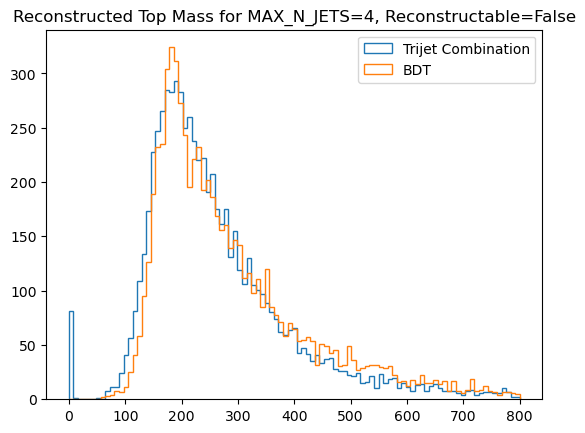

MAX_N_JETS =  5
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated features
    obtained predictions


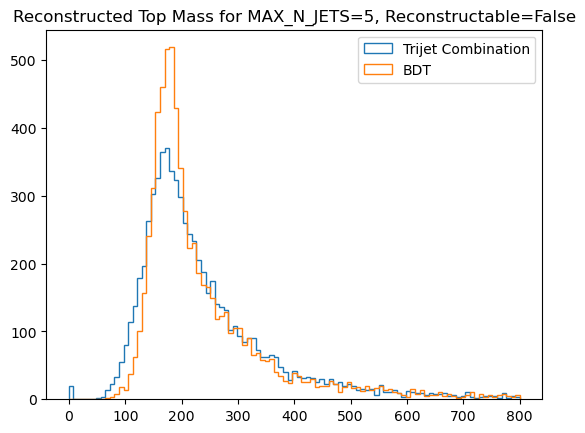

MAX_N_JETS =  6
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated features
    obtained predictions


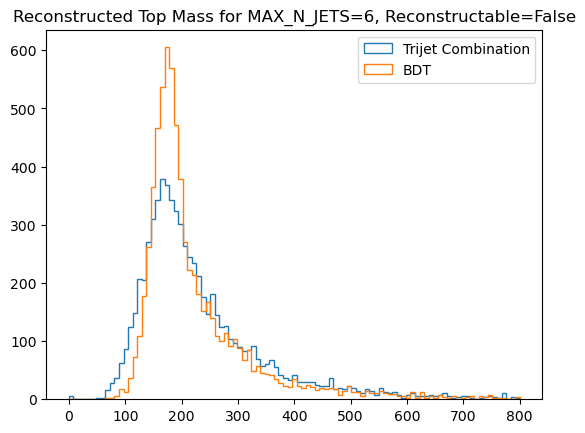

MAX_N_JETS =  7
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated features
    obtained predictions


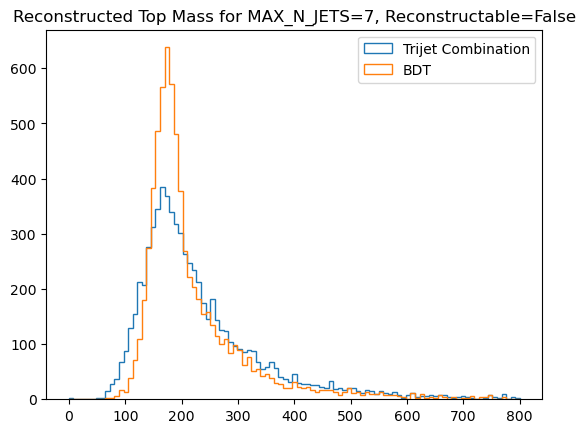

In [17]:
bdt_score_dict = {}

score_avg_topmass = np.zeros(len(MAX_N_JETS_LIST))

for MAX_N_JETS in MAX_N_JETS_LIST:

    print("MAX_N_JETS = ", MAX_N_JETS)
    jets, electrons, muons, current_even, labels = filterEvents(events.Jet, events.Electron, events.Muon, 
                                                                events.GenPart, even, 
                                                                4, MAX_N_JETS, reconstructable=False)
    print("    filtered events")
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > 0.5]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable_prev = ak.flatten(trijet_mass)
    
    # get features
    features, perm_counts = get_features(jets, 
                                         electrons, 
                                         muons, 
                                         permutations_dict)
    
    current_even = np.repeat(current_even, perm_counts)
    print("    calculated features")


    # get predictions
    predictions = np.zeros(features.shape[0])
    predictions[np.invert(current_even)] = model_even.predict_proba(features[np.invert(current_even)])[:,1]
    predictions[current_even] = model_odd.predict_proba(features[current_even])[:,1]
    print("    obtained predictions")

    BDT_results = ak.unflatten(predictions, perm_counts)
    BDT_result_combination = ak.argmax(BDT_results,axis=1)
    observable_bdt = ak.flatten(ak.unflatten(features, perm_counts)[ak.from_regular(BDT_result_combination[:, np.newaxis])])[...,6]
    
    # make observable plot
    bins = np.linspace(0,800,100)
    plt.hist(observable_prev,bins=bins,histtype='step')
    plt.hist(observable_bdt,bins=bins,histtype='step')
    plt.legend(["Trijet Combination","BDT"])
    plt.title(f"Reconstructed Top Mass for MAX_N_JETS={MAX_N_JETS}, Reconstructable=False")
    plt.show()

# Evaluation 1

First, we evaluate the performance by restricting the sample of events to those in which it is possible to construct all truth labels.

In [21]:
# set the max number of jets to consider for the first part of the study
MAX_N_JETS = 6

In [22]:
### SCORE NOT SEPARATED BY NJET

jets, electrons, muons, current_even, labels = filterEvents(events.Jet, events.Electron, events.Muon, 
                                                                events.GenPart, even, 
                                                                4, MAX_N_JETS, reconstructable=True)

print("filtered events")

## PREVIOUS METHOD (TRIJET COMBINATION WITH HIGHEST PT)
trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
trijet_labels = ak.combinations(labels, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
trijet["label"] = trijet_labels.j1 + trijet_labels.j2 + trijet_labels.j3
trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
trijet = trijet[trijet.max_btag > 0.5]  # at least one-btag in trijet candidates

# pick trijet candidate with largest pT and calculate mass of system
trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
trijet_label = trijet["label"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)]
observable_prev = ak.flatten(trijet_mass)
trijet_label = ak.fill_none(ak.flatten(trijet_label),0)

trijet_score = np.zeros(len(trijet_label))
trijet_score[trijet_label==54] = 3
trijet_score[(trijet_label==42) | (trijet_label==24) | (trijet_label==148) | (trijet_label==130)] = 2
trijet_score[(trijet_label==118) | (trijet_label==224) | (trijet_label==100) | (trijet_label==206)] = 1
print("obtained predictions via non-ML method")
    
## BDT METHOD
njet = ak.num(jets).to_numpy()
njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
# create awkward array of permutation indices
perms = ak.Array([permutations_dict[k] for k in njet])
perms_to_labels = ak.Array([labels_dict[k] for k in njet])
print("calculated perms")

# calculate event-level labels
# which combination does the truth label correspond to?
which_combination = np.zeros(len(jets), dtype=int)
combination_labels = []

for i in range(len(jets)):
    for j in range(len(perms_to_labels[i])):
        if np.array_equal(perms_to_labels[i][j],labels[i]):
            which_combination[i] = j
            combination_labels.append(1)
        else: 
            combination_labels.append(0)
combination_labels = np.array(combination_labels)
print("calculated labels")
    
# get features
features, perm_counts = get_features(jets, 
                                     electrons, 
                                     muons, 
                                     permutations_dict)
current_even = np.repeat(current_even, perm_counts)

print("calculated features")

# get predictions
predictions = np.zeros(features.shape[0])
predictions[np.invert(current_even)] = model_even.predict_proba(features[np.invert(current_even)])[:,1]
predictions[current_even] = model_odd.predict_proba(features[current_even])[:,1]
print("obtained predictions")

BDT_results = ak.unflatten(predictions, perm_counts)
BDT_result_combination = ak.argmax(BDT_results,axis=1)
observable_bdt = ak.flatten(ak.unflatten(features, perm_counts)[ak.from_regular(BDT_result_combination[:, np.newaxis])])[...,6]

# calculate performance
score_bdt_topmass = np.zeros(len(which_combination))

zipped = list(zip(which_combination.tolist(), BDT_result_combination.tolist()))
for i in range(len(which_combination)):
    score_bdt_topmass[i] = evaluation_matrices_topmass[njet[i]][zipped[i]]
print("   Three Correct = ", np.average(score_bdt_topmass==3))
print("   Two Correct = ", np.average(score_bdt_topmass==2))
print("   One Correct = ", np.average(score_bdt_topmass==1))
print("   Zero Correct = ", np.average(score_bdt_topmass==0))
    
jet_distribution = np.array([sum(njet==i)/len(njet) for i in range(4,MAX_N_JETS+1)])

topmass_prev_score_mat = np.zeros((4,MAX_N_JETS-3))
topmass_bdt_score_mat = np.zeros((4,MAX_N_JETS-3))

# calculate score for number of jets for each bracket
for n in range(4, MAX_N_JETS+1):
    
    # top mass scores
    topmass_prev_score_mat[0,n-4] = np.average(trijet_score[njet==n]==0)
    topmass_prev_score_mat[1,n-4] = np.average(trijet_score[njet==n]==1)
    topmass_prev_score_mat[2,n-4] = np.average(trijet_score[njet==n]==2)
    topmass_prev_score_mat[3,n-4] = np.average(trijet_score[njet==n]==3)
    topmass_bdt_score_mat[0,n-4] = np.average(score_bdt_topmass[njet==n]==0)
    topmass_bdt_score_mat[1,n-4] = np.average(score_bdt_topmass[njet==n]==1)
    topmass_bdt_score_mat[2,n-4] = np.average(score_bdt_topmass[njet==n]==2)
    topmass_bdt_score_mat[3,n-4] = np.average(score_bdt_topmass[njet==n]==3)
    
# calculate weighted average using distribution of number of jets
print("calculated scores")

         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
        Training Filter Keeps 19.850345898630525% of Events
filtered events
obtained predictions via non-ML method
calculated perms
calculated labels
calculated features
obtained predictions
   Three Correct =  0.60099573257468
   Two Correct =  0.29871977240398295
   One Correct =  0.08819345661450925
   Zero Correct =  0.01209103840682788
calculated scores


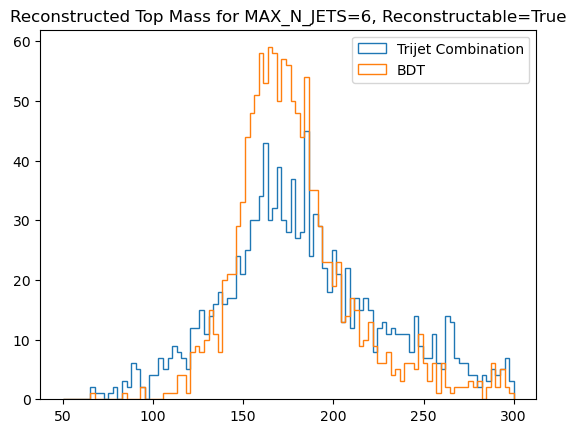

In [23]:
bins = np.linspace(50,300,100)
plt.hist(observable_prev,bins=bins,histtype='step')
plt.hist(observable_bdt,bins=bins,histtype='step')
plt.legend(["Trijet Combination","BDT"])
plt.title(f"Reconstructed Top Mass for MAX_N_JETS={MAX_N_JETS}, Reconstructable=True")
plt.show()

In [24]:
bdt_topmass_scores = np.matmul(topmass_bdt_score_mat, jet_distribution)
prev_topmass_scores = np.matmul(topmass_prev_score_mat, jet_distribution)

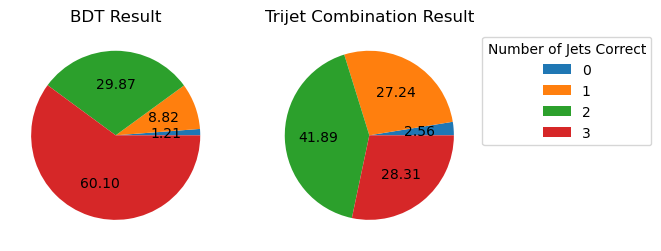

In [25]:
# make pie charts
fig, axs = plt.subplots(1,2,figsize=(6,4))

axs[0].pie(bdt_topmass_scores,autopct='%.2f')
axs[1].pie(prev_topmass_scores,autopct='%.2f')
axs[0].set_title(f"BDT Result")
axs[1].set_title(f"Trijet Combination Result")
axs[1].legend(["0","1","2","3"], 
              bbox_to_anchor=(1,1), title = "Number of Jets Correct")
                    
fig.show()

# Evaluation 2

Next, we evaluate the performance for all events in which it is possible to fully reconstruct, but separate the calculations by number of jets (and type of jet/jet label)

n =  4
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
        Training Filter Keeps 8.075674149371736% of Events
    filtered events
    calculated perms
    calculated labels
    calculated features
    obtained predictions
    calculated scores


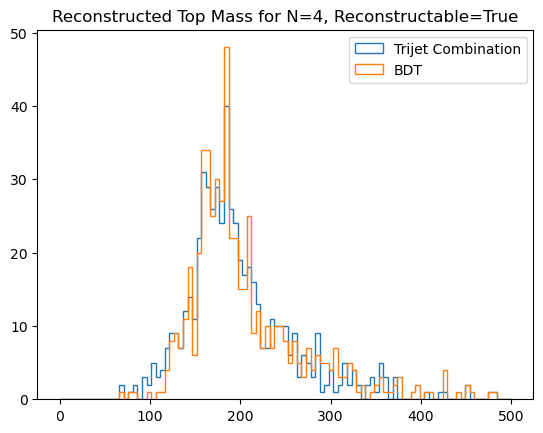

n =  5
         3.2 % of events survived event_filters
         2.22 % of events survived region_filter
        Training Filter Keeps 24.290859972985142% of Events
    filtered events
    calculated perms
    calculated labels
    calculated features
    obtained predictions
    calculated scores


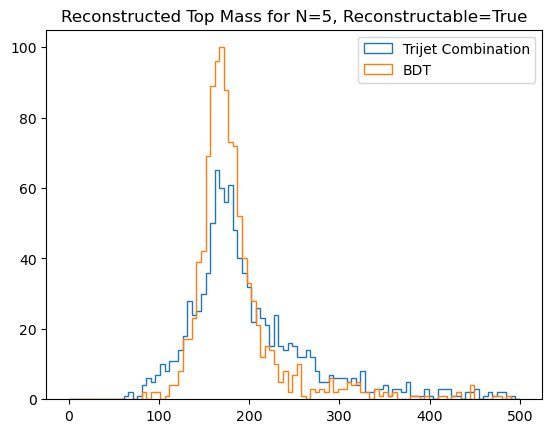

n =  6
         1.3599999999999999 % of events survived event_filters
         1.01 % of events survived region_filter
        Training Filter Keeps 21.83622828784119% of Events
    filtered events
    calculated perms
    calculated labels
    calculated features
    obtained predictions
    calculated scores


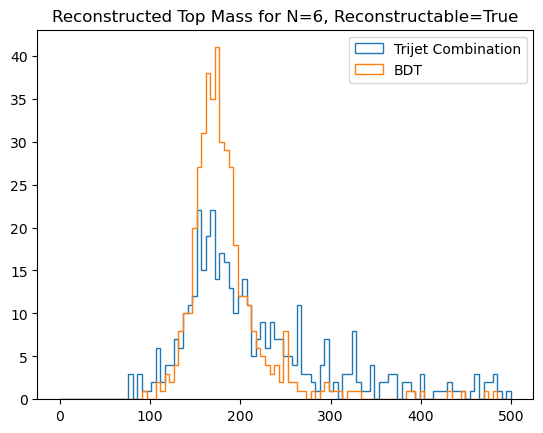

In [29]:
# top mass reconstruction scores
bdt_topmass_score_dict = {}
prev_topmass_score_dict = {}


for n in range(4,MAX_N_JETS+1):
    
    print("n = ", n)
    # filter data
    jets, electrons, muons, current_even, labels = filterEvents(events.Jet, events.Electron, events.Muon, events.GenPart, even, n, n)
    print("    filtered events")
    
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet_labels = ak.combinations(labels, 3, fields=["j1", "j2", "j3"])
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
    trijet["label"] = trijet_labels.j1 + trijet_labels.j2 + trijet_labels.j3
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > 0.5]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    trijet_label = trijet["label"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)]
    observable_prev = ak.flatten(trijet_mass)
    trijet_label = ak.fill_none(ak.flatten(trijet_label),False)
    
    trijet_score = np.zeros(len(trijet_label))
    trijet_score[trijet_label==54] = 3
    trijet_score[(trijet_label==42) | (trijet_label==24) | (trijet_label==148) | (trijet_label==130)] = 2
    trijet_score[(trijet_label==118) | (trijet_label==224) | (trijet_label==100) | (trijet_label==206)] = 1

    
    njet = ak.num(jets).to_numpy()
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[k] for k in njet])
    perms_to_labels = ak.Array([labels_dict[k] for k in njet])
    print("    calculated perms")

    # calculate event-level labels
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    combination_labels = []

    for i in range(len(jets)):
        for j in range(len(perms_to_labels[i])):
            if np.array_equal(perms_to_labels[i][j],labels[i]):
                which_combination[i] = j
                combination_labels.append(1)
            else: 
                combination_labels.append(0)

    combination_labels = np.array(combination_labels)
    print("    calculated labels")
    
    # get features
    features, perm_counts = get_features(jets, 
                                         electrons, 
                                         muons, 
                                         permutations_dict)
    current_even = np.repeat(current_even, perm_counts)
    print("    calculated features")

    # get predictions
    predictions = np.zeros(features.shape[0])
    predictions[np.invert(current_even)] = model_even.predict_proba(features[np.invert(current_even)])[:,1]
    predictions[current_even] = model_odd.predict_proba(features[current_even])[:,1]
    print("    obtained predictions")

    BDT_results = ak.unflatten(predictions, perm_counts)
    BDT_result_combination = ak.argmax(BDT_results,axis=1)
    observable_bdt = ak.flatten(ak.unflatten(features, perm_counts)[ak.from_regular(BDT_result_combination[:, np.newaxis])])[...,6]

    # calculate performance
    score_topmass = np.zeros(len(which_combination))

    zipped = list(zip(which_combination.tolist(), BDT_result_combination.tolist()))
    for i in range(len(which_combination)):
        score_topmass[i] = evaluation_matrices_topmass[n][zipped[i]]
    
    # scores for top mass reconstruction
    bdt_score_topmass = np.zeros(4)
    prev_score_topmass = np.zeros(4)
    for i in range(4):
        bdt_score_topmass[i] =  sum(score_topmass==i)/len(score_topmass)
        prev_score_topmass[i] =  sum(trijet_score==i)/len(trijet_score)
    bdt_topmass_score_dict[n] = bdt_score_topmass
    prev_topmass_score_dict[n] = prev_score_topmass
    
    print("    calculated scores")
    
    
    bins = np.linspace(0,500,100)
    plt.hist(observable_prev,bins=bins,histtype='step')
    plt.hist(observable_bdt,bins=bins,histtype='step')
    plt.legend(["Trijet Combination","BDT"])
    plt.title(f"Reconstructed Top Mass for N={n}, Reconstructable=True")
    plt.show()

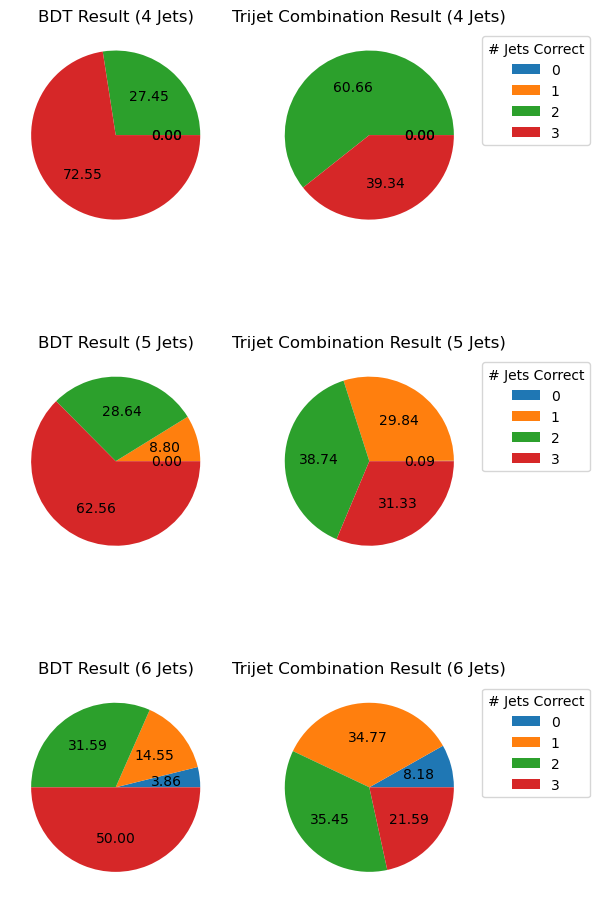

In [30]:
# top mass reconstruction plots
fig, axs = plt.subplots(MAX_N_JETS-3,2,figsize=(6,4*(MAX_N_JETS-3)))

for i in range(MAX_N_JETS-3):

    axs[i,0].pie(bdt_topmass_score_dict[i+4],autopct='%.2f')
    axs[i,1].pie(prev_topmass_score_dict[i+4],autopct='%.2f')
    axs[i,0].set_title(f"BDT Result ({i+4} Jets)")
    axs[i,1].set_title(f"Trijet Combination Result ({i+4} Jets)")
    
    axs[i,1].legend(range(len(bdt_topmass_score_dict[i+4])), bbox_to_anchor=(1,1), title = "# Jets Correct")
                    
fig.show()

# Evaluation 3

Now we want to see the effect of `MAX_N_JETS` on overall efficiency. So we will not filter to events that are fully reconstructable.

In [10]:
MAX_N_JETS_LIST = list(range(4,8)) # values of MAX_N_JETS to consider

MAX_N_JETS =  4
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated perms
    calculated features
obtained predictions
    obtained results


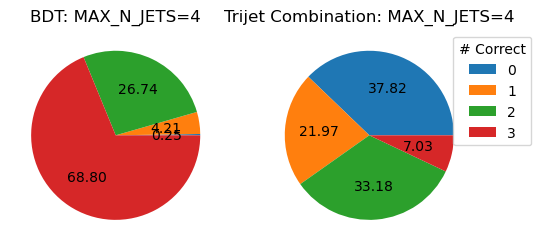

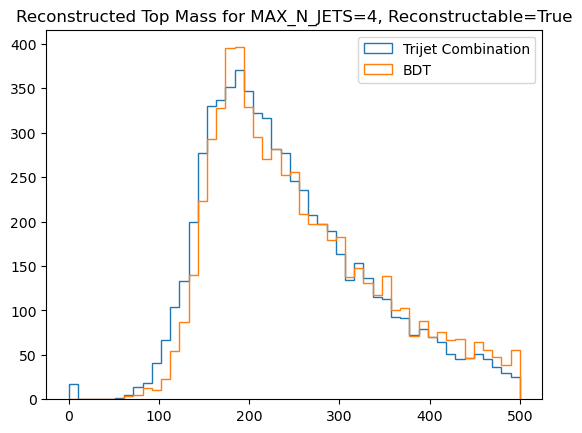

MAX_N_JETS =  5
         5.58 % of events survived event_filters
         3.54 % of events survived region_filter
    filtered events
    calculated perms


In [ ]:
bdt_score_dict = {}

score_avg_topmass = np.zeros(len(MAX_N_JETS_LIST))

for MAX_N_JETS in MAX_N_JETS_LIST:
    fig, ax = plt.subplots(1,2,figsize=(6,4*len(MAX_N_JETS_LIST)))

    print("MAX_N_JETS = ", MAX_N_JETS)
    jets, electrons, muons, current_even, labels = filterEvents(events.Jet, events.Electron, events.Muon, 
                                                                events.GenPart, even, 
                                                                4, MAX_N_JETS, reconstructable=False)
    print("    filtered events")
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet_labels = ak.combinations(labels, 3, fields=["j1", "j2", "j3"])
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
    trijet["label"] = trijet_labels.j1 + trijet_labels.j2 + trijet_labels.j3
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > 0.5]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    trijet_label = trijet["label"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)]
    observable_prev = ak.flatten(trijet_mass)
    trijet_label = ak.fill_none(ak.flatten(trijet_label),False)
    
    trijet_score = np.zeros(len(trijet_label))
    trijet_score[trijet_label==54] = 3
    trijet_score[(trijet_label==42) | (trijet_label==24) | (trijet_label==148) | (trijet_label==130)] = 2
    trijet_score[(trijet_label==118) | (trijet_label==224) | (trijet_label==100) | (trijet_label==206)] = 1
    
    njet = ak.num(jets).to_numpy()
    njet[njet>MAX_N_JETS] = MAX_N_JETS
    
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[k] for k in njet])
    perms_to_labels = ak.Array([labels_dict[k] for k in njet])
    print("    calculated perms")
    
    # calculate event-level labels
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    combination_labels = []

    for i in range(len(jets)):
        for j in range(len(perms_to_labels[i])):
            if np.array_equal(perms_to_labels[i][j],labels[i]):
                which_combination[i] = j
                combination_labels.append(1)
            else: 
                combination_labels.append(0)
    
    # get features
    features, perm_counts = get_features(jets, 
                                         electrons, 
                                         muons, 
                                         permutations_dict)
    current_even = np.repeat(current_even, perm_counts)
    print("    calculated features")

    # get predictions
    predictions = np.zeros(features.shape[0])
    predictions[np.invert(current_even)] = model_even.predict_proba(features[np.invert(current_even)])[:,1]
    predictions[current_even] = model_odd.predict_proba(features[current_even])[:,1]
    print("obtained predictions")

    BDT_results = ak.unflatten(predictions, perm_counts)
    BDT_result_combination = ak.argmax(BDT_results,axis=1)
    observable_bdt = ak.flatten(ak.unflatten(features, perm_counts)[ak.from_regular(BDT_result_combination[:, np.newaxis])])[...,6]
    
    label_result = ak.flatten(perms_to_labels[ak.from_regular(BDT_result_combination[:, np.newaxis])])

    # where truth labels are present in predicted combination
    where_topmass_result = (label_result==24) | (label_result==6) | (label_result==-6)

    # where truth labels are present in truth combination
    where_topmass_truth = (labels==24) | (labels==6) | (labels==-6)
    
    
    score_bdt_topmass = np.zeros(len(label_result))
    for evtnum in range(len(label_result)):

        for ind in np.where(where_topmass_truth[evtnum])[0]:
            if ind in np.where(where_topmass_result[evtnum])[0]: 
                score_bdt_topmass[evtnum] += 1
        if score_bdt_topmass[evtnum]>3: score_bdt_topmass[evtnum] = 3
    
    print("    obtained results")
    
    score_avg_topmass[MAX_N_JETS-4] = np.average(score_bdt_topmass)
    
    # make pie charts
    ax[0].pie([sum(score_bdt_topmass==0)/len(score_bdt_topmass), 
               sum(score_bdt_topmass==1)/len(score_bdt_topmass), 
               sum(score_bdt_topmass==2)/len(score_bdt_topmass), 
               sum(score_bdt_topmass==3)/len(score_bdt_topmass)],
              autopct='%.2f')
    ax[0].set_title(f"BDT: MAX_N_JETS={MAX_N_JETS}")
    ax[1].pie([sum(trijet_score==0)/len(trijet_score), 
               sum(trijet_score==1)/len(trijet_score), 
               sum(trijet_score==2)/len(trijet_score), 
               sum(trijet_score==3)/len(trijet_score)],
              autopct='%.2f')
    ax[1].set_title(f"Trijet Combination: MAX_N_JETS={MAX_N_JETS}")
    ax[1].legend([0,1,2,3], title="# Correct", loc='upper right', bbox_to_anchor=(1.3,1))
    
    plt.show()
    
    # make observable plot
    bins = np.linspace(0,500,50)
    plt.hist(observable_prev,bins=bins,histtype='step')
    plt.hist(observable_bdt,bins=bins,histtype='step')
    plt.legend(["Trijet Combination","BDT"])
    plt.title(f"Reconstructed Top Mass for MAX_N_JETS={MAX_N_JETS}, Reconstructable=True")
    plt.show()

In [13]:
score_avg_topmass

array([3.        , 3.        , 2.96799431, 2.95960312])